In [2]:
import pandas as pd

In [3]:
df=pd.read_csv("Data\\commentsCleanData.csv")
df

,videoId,title,videoLikes,videoViews,commenter_name,comments
0,0lPWDcsqg98,I accidentally threw my sisters cat away,61639,1067796,@Cookiecookiecookecookiecookie,the mini heart attack sara had
1,0lPWDcsqg98,I accidentally threw my sisters cat away,61639,1067796,@Ryth-8888,bro i hate cats
2,0lPWDcsqg98,I accidentally threw my sisters cat away,61639,1067796,@SamsungOmniaHD79,the beef keemo has with mochi
3,0lPWDcsqg98,I accidentally threw my sisters cat away,61639,1067796,@daynadulpina2699,the cat said please keemo leave me alone
4,0lPWDcsqg98,I accidentally threw my sisters cat away,61639,1067796,@user-gi2vp1oc4i,you are mean
...,...,...,...,...,...,...
23117,01IAzYPhC1w,Keemokazi - Hot Cheetos,4047,239774,@maribelzamora3575,i m going on my first day of work today i have...
23118,01IAzYPhC1w,Keemokazi - Hot Cheetos,4047,239774,@Rackyroblox,peaple watching this in 2024
23119,01IAzYPhC1w,Keemokazi - Hot Cheetos,4047,239774,@peteroni21,people
23120,01IAzYPhC1w,Keemokazi - Hot Cheetos,4047,239774,@MilesWMG,im watching this in 2024


In [4]:
df['comments'] = df['comments'].astype(str)
df['comments'] = df['comments'].str.lower()


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['comments'].fillna(''))

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


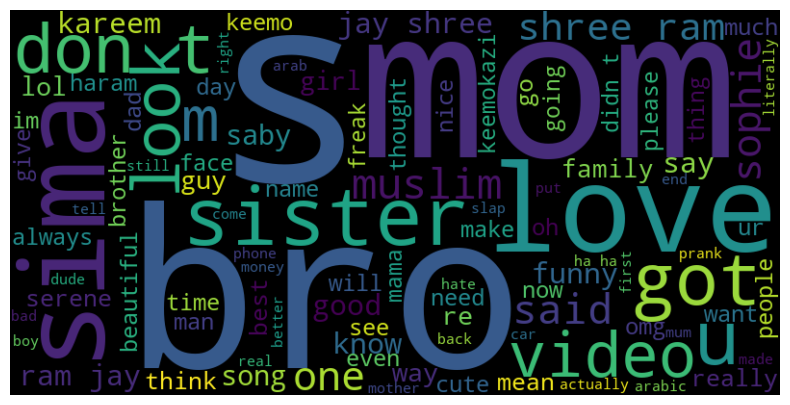

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df['comments'].fillna('')))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [13]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display the top words for each topic
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #1:
saby song best keemo omg im mama brother money car slap mom cool going way
Topic #2:
got muslim lol right bro sisters oh girl want dying phone mother dumb didn crazy
Topic #3:
bro like serene don dad know haram just thought stop end 10 old hate does
Topic #4:
love sima mom funny sophie sister like cute mean beautiful looks video videos ur birthday
Topic #5:
did good family said freak face nice kareem think big keemokazi arabic people mom bro


In [8]:
from sklearn.preprocessing import LabelEncoder

df['videoId_encoded'] = LabelEncoder().fit_transform(df['videoId'])
df['commenter_encoded'] = LabelEncoder().fit_transform(df['commenter_name'])

interaction_matrix = df.pivot_table(index='commenter_encoded', 
                                    columns='videoId_encoded', 
                                    values='comments', 
                                    aggfunc='count', 
                                    fill_value=0)

interaction_matrix.fillna(0, inplace=True)


In [9]:
from sklearn.decomposition import NMF

# Apply Non-negative Matrix Factorization
nmf = NMF(n_components=5, random_state=42)
user_features = nmf.fit_transform(interaction_matrix)
video_features = nmf.components_

# Recommend videos for a user
user_id = 0  # Example user ID
user_vector = user_features[user_id]
recommendations = user_vector.dot(video_features)
recommended_video_ids = recommendations.argsort()[::-1][:5]  # Top 5 recommendations

print("Recommended video IDs:", recommended_video_ids)


Recommended video IDs: [1135  642  943  242    7]


In [10]:
from sklearn.preprocessing import StandardScaler

# Combine TF-IDF features with video metadata (likes, views)
metadata_features = df[['videoLikes', 'videoViews']].fillna(0)
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_features)

combined_features = pd.concat([tfidf_df, pd.DataFrame(metadata_scaled)], axis=1)


In [11]:
from sklearn.neighbors import NearestNeighbors


combined_features.columns = combined_features.columns.astype(str)

knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(combined_features.values)  


# Recommend similar videos
video_index = 0  
distances, indices = knn.kneighbors([combined_features.iloc[video_index]])

print("Recommended videos for video index", video_index, ":", indices[0])



Recommended videos for video index 0 : [   0 9330 9318 6801 9327]


In [12]:
# Recommended video indices
recommended_indices = indices[0]

# Extract video titles
recommended_titles = df.iloc[recommended_indices]['title']

recommended_titles = recommended_titles.drop_duplicates()

# Print recommended video titles
print("Recommended video titles:")
for title in recommended_titles:
    print(title)


Recommended video titles:
I accidentally threw my sisters cat away 
Don’t pull this prank on your mom 
I blew my entire house up 
